In [1]:
from __future__ import absolute_import, division, print_function
import os
import random
import shap
import xgboost as xgb
from bayes_opt import BayesianOptimization
from joblib import Parallel, delayed
from lime import lime_tabular
from matplotlib.ticker import StrMethodFormatter
from scipy import sparse
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one, _name_estimators
from sklearn.pipeline import make_pipeline
from sklearn.tree import export_graphviz
import math
from sklearn.linear_model import LogisticRegression
from fancyimpute import IterativeImputer, KNN
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from factor_analyzer import FactorAnalyzer
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Built on Conda 4.10.1

## Code is seperated between logistic regression / machine learning model


In [2]:
# Read in the data
train = pd.read_csv("../Data/Simulated_Data_Train.csv")
test = pd.read_csv("../Data/Simulated_Data_Test.csv")
validate=pd.read_csv("../Data/Simulated_Data_Validation.csv")

## EDA / Data Preprocessing

In [3]:
#exploring the data
train.dtypes

tot_credit_debt                       float64
avg_card_debt                         float64
credit_age                            float64
credit_good_age                       float64
card_age                              float64
non_mtg_acc_past_due_12_months_num    float64
non_mtg_acc_past_due_6_months_num     float64
mortgages_past_due_6_months_num       float64
credit_past_due_amount                float64
inq_12_month_num                      float64
card_inq_24_month_num                 float64
card_open_36_month_num                float64
auto_open_ 36_month_num               float64
uti_card                              float64
uti_50plus_pct                        float64
uti_max_credit_line                   float64
uti_card_50plus_pct                   float64
ind_acc_XYZ                           float64
rep_income                            float64
States                                 object
Default_ind                           float64
dtype: object

Number of people who DON'T default: 18414
Number of people who DO default: 1586


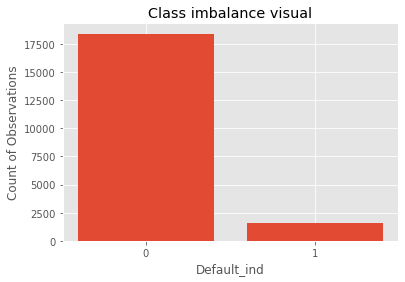

In [4]:
# Visual of class imbalance
plt.style.use('ggplot')
df_default_0 = train[train['Default_ind']==0.0]
default_0 = len(df_default_0)
df_default_1 = train[train['Default_ind']==1.0]
default_1 = len(df_default_1)
plt.bar([0,1],[default_0,default_1])
plt.xticks([0,1])
plt.ylabel('Count of Observations')
plt.xlabel('Default_ind')
plt.title('Class imbalance visual')
print(f"Number of people who DON'T default: {default_0}")
print(f"Number of people who DO default: {default_1}")

Mean of States default proportion: 0.08617514
Between-State Variance: 0.00002420


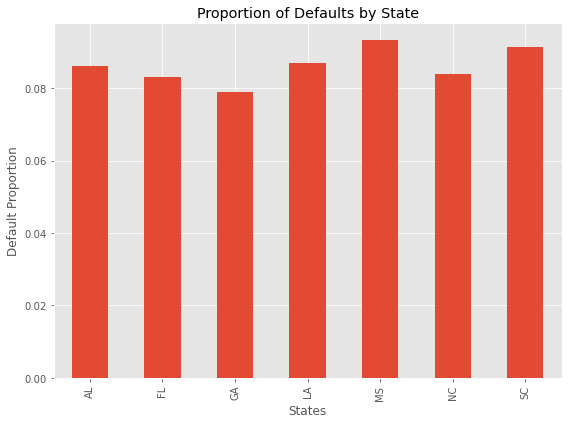

In [5]:
# Default Proportion by state

states = list({i for i in train.States})
states_default = train[train['Default_ind'] == 1].groupby('States')['Default_ind'].count()
states_no_default = train[train['Default_ind'] == 0].groupby('States')['Default_ind'].count()
states_prop_default = states_default/states_no_default

fig, ax = plt.subplots(figsize=(8,6))
states_prop_default.plot.bar(y='Proportion of Defaults',title='Proportion of Defaults by State')
ax.set_ylabel('Default Proportion')
fig.tight_layout()

plt.savefig('state_default_prop.jpg')
# plt.show()

print(f'Mean of States default proportion: {states_prop_default.mean():.8f}')
print(f'Between-State Variance: {states_prop_default.var():.8f}')

Based on the lack of variability across the States, we chose not to explore the relationship between states and our response.

In [6]:
train_states = train['States']
test_states = test['States']
validate_states = validate['States']

train = train.drop("States",axis=1)
test = test.drop("States",axis=1)
validate = validate.drop("States",axis=1)

In [7]:
train.isna().sum()

tot_credit_debt                          0
avg_card_debt                            0
credit_age                               0
credit_good_age                          0
card_age                                 0
non_mtg_acc_past_due_12_months_num       0
non_mtg_acc_past_due_6_months_num        0
mortgages_past_due_6_months_num          0
credit_past_due_amount                   0
inq_12_month_num                         0
card_inq_24_month_num                    0
card_open_36_month_num                   0
auto_open_ 36_month_num                  0
uti_card                                 0
uti_50plus_pct                           0
uti_max_credit_line                      0
uti_card_50plus_pct                   2055
ind_acc_XYZ                              0
rep_income                            1570
Default_ind                              0
dtype: int64

In [8]:


train_mice_imputed = train.copy(deep=True)
mice_imputer = IterativeImputer()
train_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(train)

train_KNN_imputed = train.copy(deep=True)
KNN_imputer = KNN()
train_KNN_imputed.iloc[:, :] = KNN_imputer.fit_transform(train)

validate_mice_imputed = validate.copy(deep=True)
mice_imputer = IterativeImputer()
validate_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(validate)

validate_KNN_imputed = validate.copy(deep=True)
KNN_imputer = KNN()
validate_KNN_imputed.iloc[:, :] = KNN_imputer.fit_transform(validate)

test_mice_imputed = test.copy(deep=True)
mice_imputer = IterativeImputer()
test_mice_imputed.iloc[:, :] = mice_imputer.fit_transform(test)

test_KNN_imputed = test.copy(deep=True)
KNN_imputer = KNN()
test_KNN_imputed.iloc[:, :] = KNN_imputer.fit_transform(test)

Imputing row 1/20000 with 1 missing, elapsed time: 69.662
Imputing row 101/20000 with 0 missing, elapsed time: 69.716
Imputing row 201/20000 with 0 missing, elapsed time: 69.720
Imputing row 301/20000 with 0 missing, elapsed time: 69.722
Imputing row 401/20000 with 0 missing, elapsed time: 69.724
Imputing row 501/20000 with 0 missing, elapsed time: 69.726
Imputing row 601/20000 with 0 missing, elapsed time: 69.727
Imputing row 701/20000 with 0 missing, elapsed time: 69.729
Imputing row 801/20000 with 0 missing, elapsed time: 69.731
Imputing row 901/20000 with 0 missing, elapsed time: 69.733
Imputing row 1001/20000 with 0 missing, elapsed time: 69.735
Imputing row 1101/20000 with 1 missing, elapsed time: 69.736
Imputing row 1201/20000 with 0 missing, elapsed time: 69.739
Imputing row 1301/20000 with 0 missing, elapsed time: 69.742
Imputing row 1401/20000 with 1 missing, elapsed time: 69.744
Imputing row 1501/20000 with 0 missing, elapsed time: 69.746
Imputing row 1601/20000 with 0 missi

Imputing row 15901/20000 with 0 missing, elapsed time: 70.075
Imputing row 16001/20000 with 0 missing, elapsed time: 70.078
Imputing row 16101/20000 with 0 missing, elapsed time: 70.080
Imputing row 16201/20000 with 0 missing, elapsed time: 70.083
Imputing row 16301/20000 with 0 missing, elapsed time: 70.084
Imputing row 16401/20000 with 1 missing, elapsed time: 70.086
Imputing row 16501/20000 with 0 missing, elapsed time: 70.089
Imputing row 16601/20000 with 0 missing, elapsed time: 70.091
Imputing row 16701/20000 with 0 missing, elapsed time: 70.094
Imputing row 16801/20000 with 0 missing, elapsed time: 70.098
Imputing row 16901/20000 with 0 missing, elapsed time: 70.100
Imputing row 17001/20000 with 0 missing, elapsed time: 70.103
Imputing row 17101/20000 with 0 missing, elapsed time: 70.105
Imputing row 17201/20000 with 0 missing, elapsed time: 70.108
Imputing row 17301/20000 with 0 missing, elapsed time: 70.110
Imputing row 17401/20000 with 1 missing, elapsed time: 70.112
Imputing

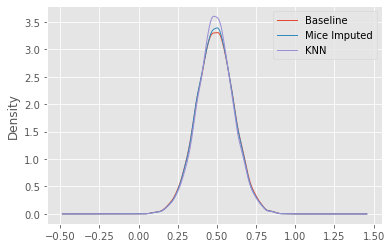

In [9]:
train['uti_card_50plus_pct'].dropna().plot(kind='kde',linewidth=1)
train_mice_imputed['uti_card_50plus_pct'].plot(kind='kde',linewidth=1)
train_KNN_imputed['uti_card_50plus_pct'].plot(kind='kde',linewidth=1)

uti_card_labels = ['Baseline','Mice Imputed','KNN']
plt.legend(uti_card_labels)
plt.savefig('uti_card_50plus_pct_imputed')

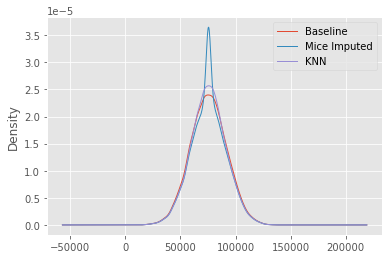

In [10]:
train['rep_income'].dropna().plot(kind='kde',linewidth = 1)
train_mice_imputed['rep_income'].plot(kind='kde',linewidth = 1)
train_KNN_imputed['rep_income'].plot(kind='kde',linewidth = 1)

rep_income_labels = ['Baseline','Mice Imputed','KNN']
plt.legend(rep_income_labels)
plt.savefig('rep_income_imputed')

In [11]:
train['uti_card_50plus_pct'] = train_mice_imputed['uti_card_50plus_pct']
train['rep_income'] = train_KNN_imputed['rep_income']

validate['uti_card_50plus_pct'] = validate_mice_imputed['uti_card_50plus_pct']
validate['rep_income'] = validate_KNN_imputed['rep_income']

test['uti_card_50plus_pct'] = test_mice_imputed['uti_card_50plus_pct']
test['rep_income'] = test_KNN_imputed['rep_income']

In [12]:
def kde_target(var_name, df):

    # Calculate medians for repaid vs not repaid
    avg_not_default = df.loc[df['Default_ind'] == 0, var_name].median()
    avg_default = df.loc[df['Default_ind'] == 1, var_name].median()

    plt.figure(figsize = (12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['Default_ind'] == 0, var_name], label = 'Default_ind == 0')
    sns.kdeplot(df.loc[df['Default_ind'] == 1, var_name], label = 'Default_ind == 1')

    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();


def kde_target_treatment(var_name, df):

    # Calculate medians for repaid vs not repaid
    avg_not_default = df.loc[df['ind_acc_XYZ'] == 0, var_name].median()
    avg_default = df.loc[df['ind_acc_XYZ'] == 1, var_name].median()

    plt.figure(figsize = (12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['ind_acc_XYZ'] == 0, var_name], label = 'ind_acc_XYZ == 0')
    sns.kdeplot(df.loc[df['ind_acc_XYZ'] == 1, var_name], label = 'ind_acc_XYZ == 1')

    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();


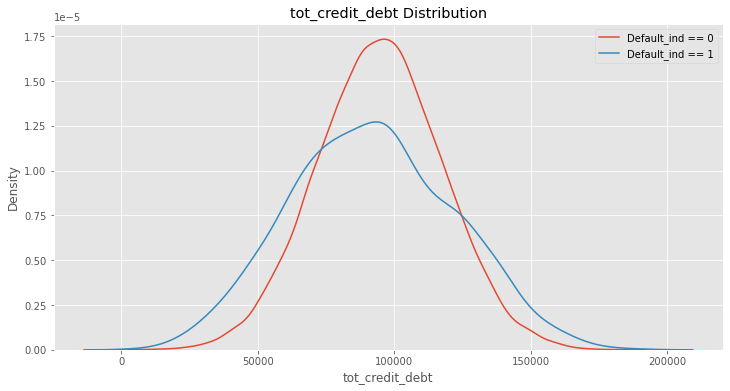

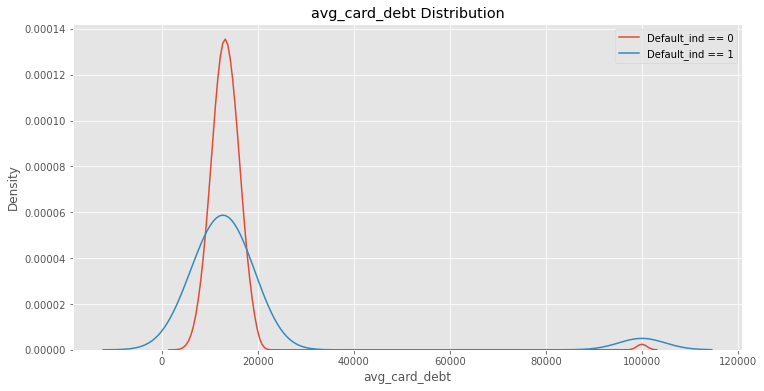

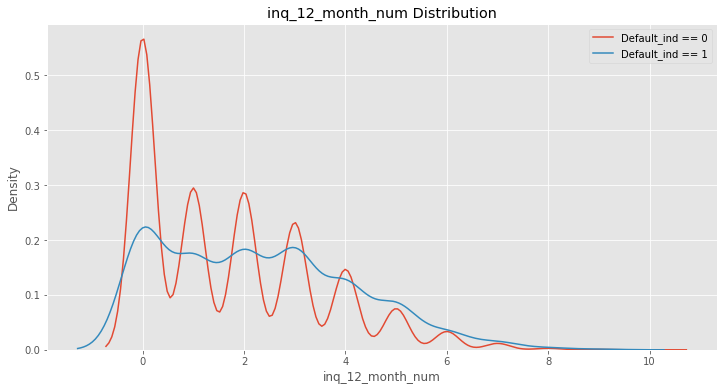

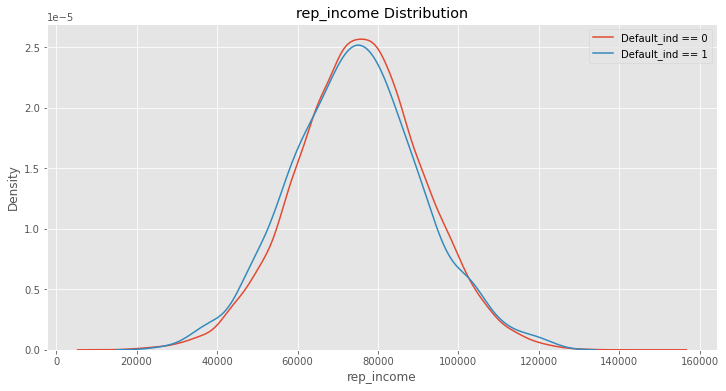

In [13]:
anom_train = ['tot_credit_debt','avg_card_debt','inq_12_month_num','rep_income']
for var in anom_train:
    kde_target(var, train)

No handles with labels found to put in legend.


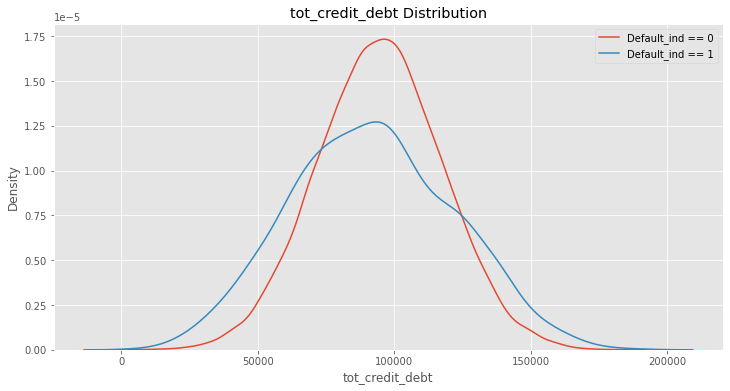

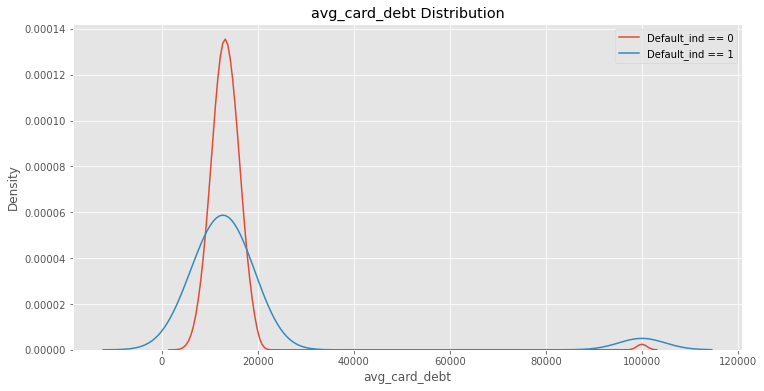

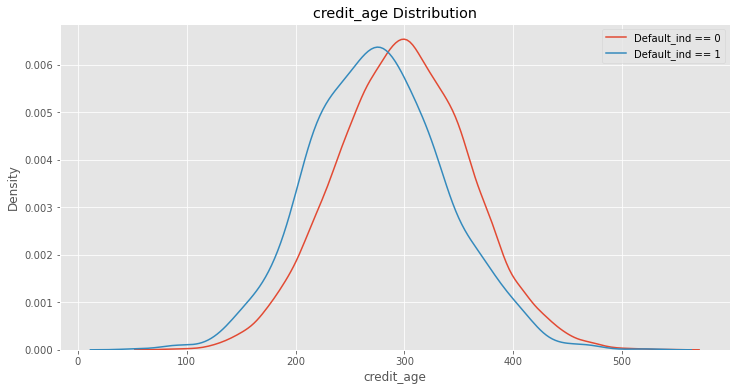

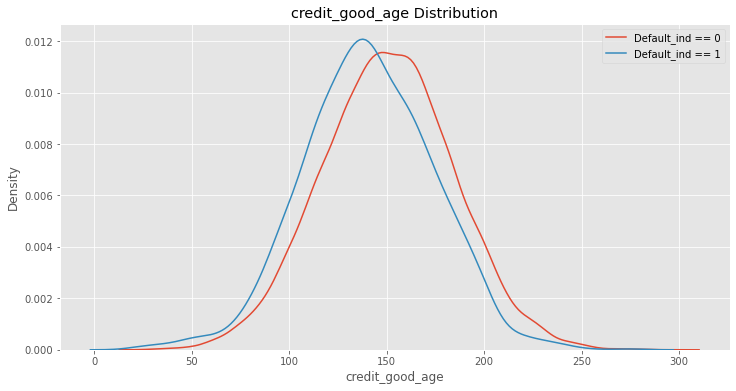

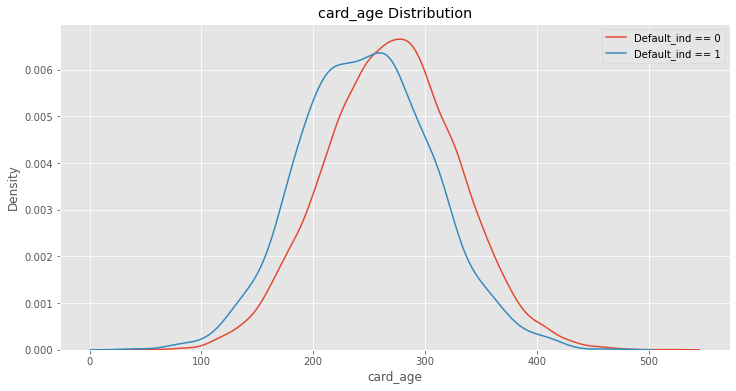

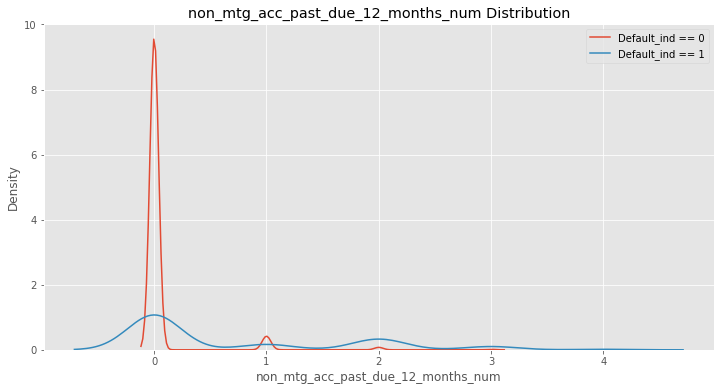

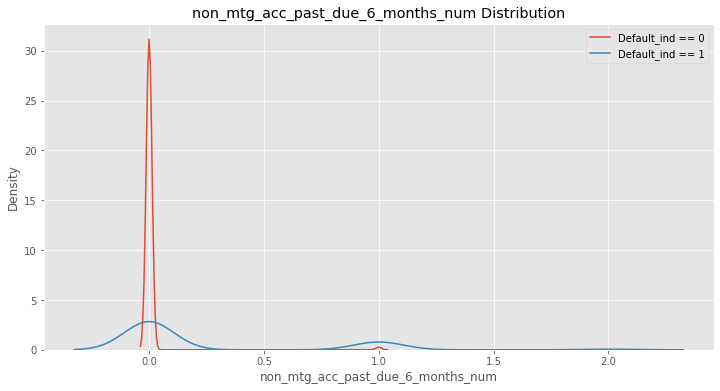

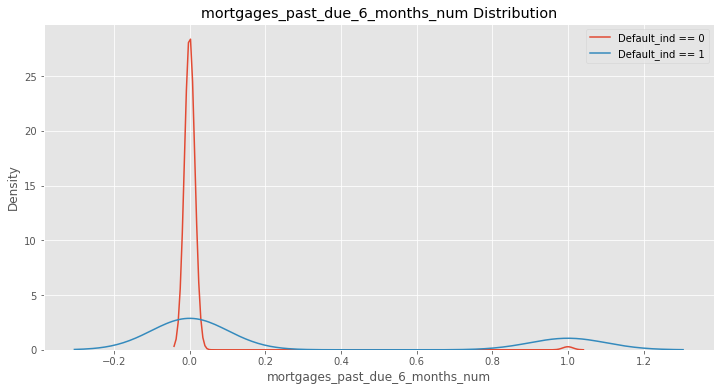

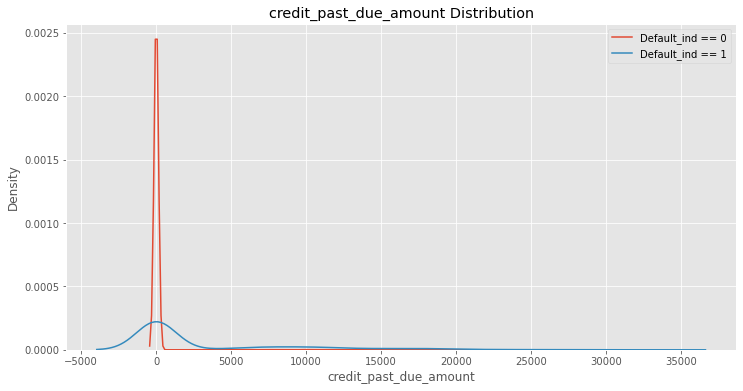

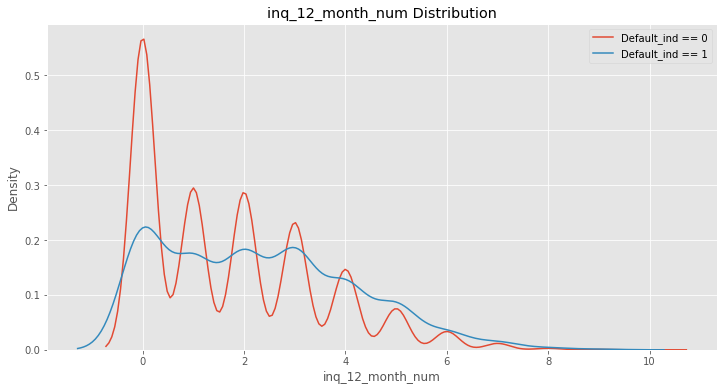

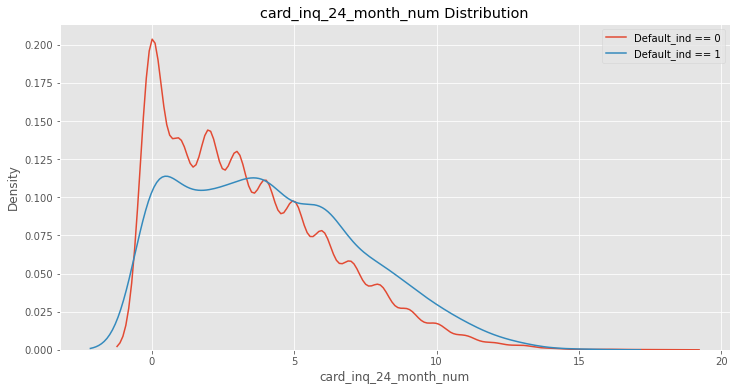

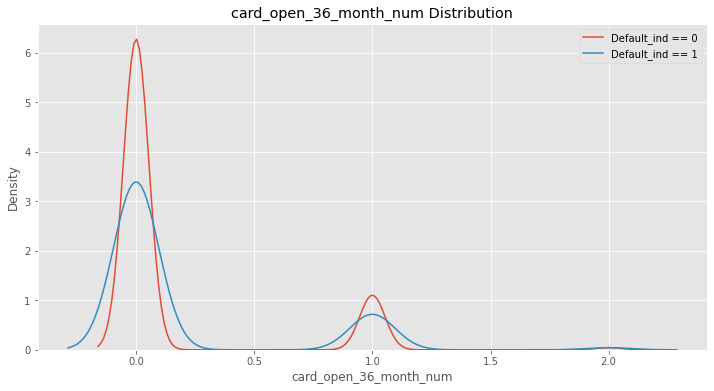

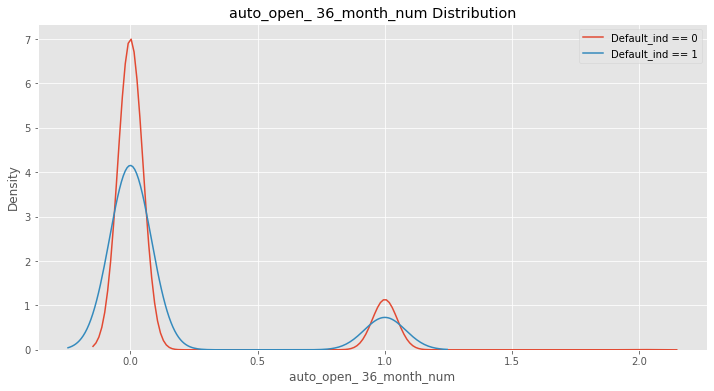

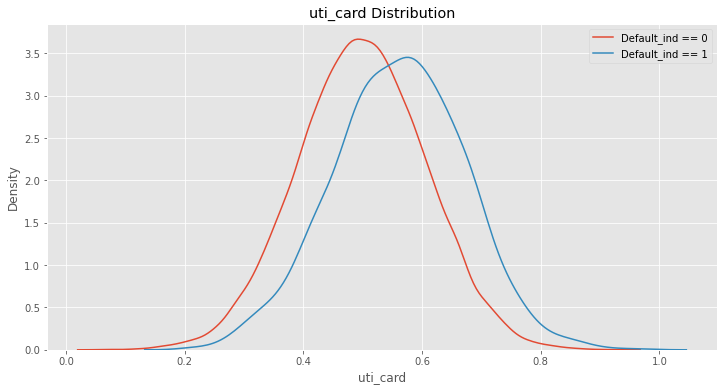

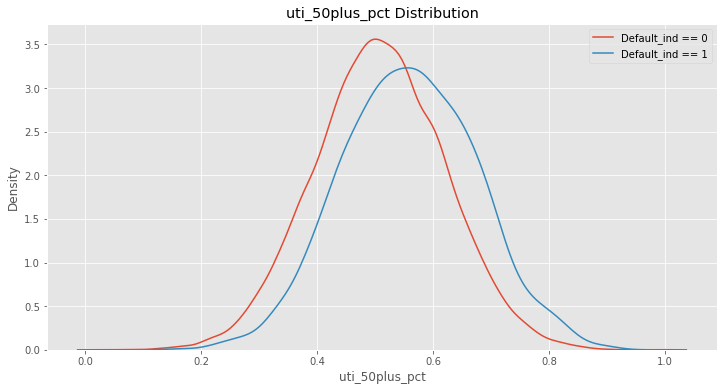

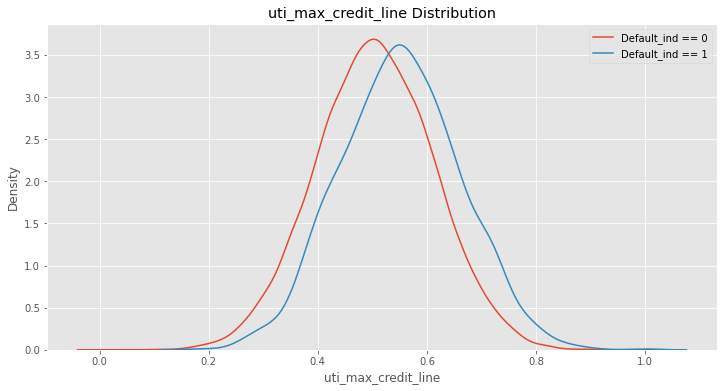

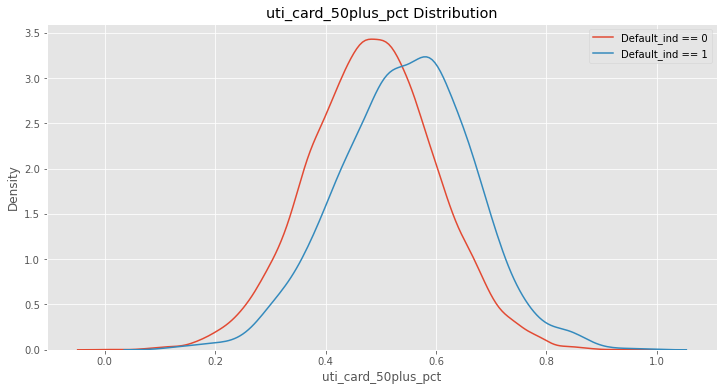

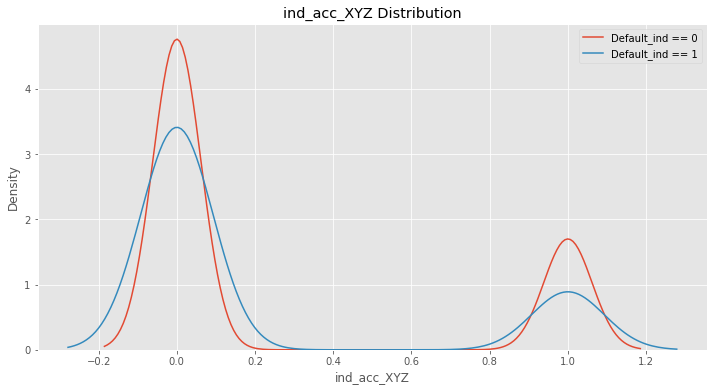

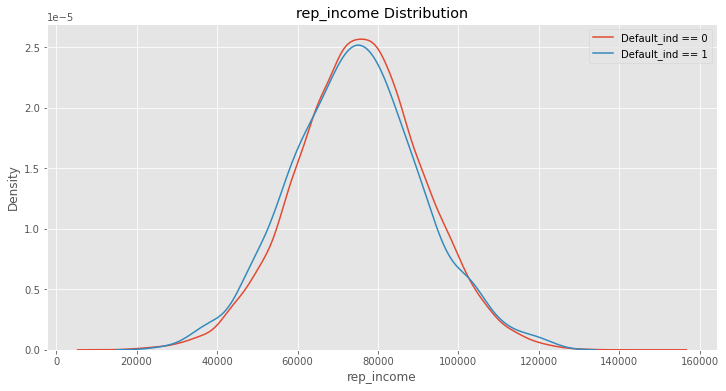

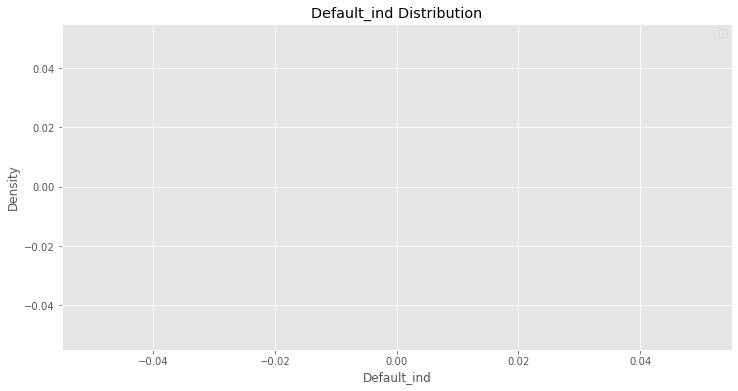

In [14]:
# Evaluating effect on Default_ind
for var in list(train.columns):
    kde_target(var, train)


No handles with labels found to put in legend.


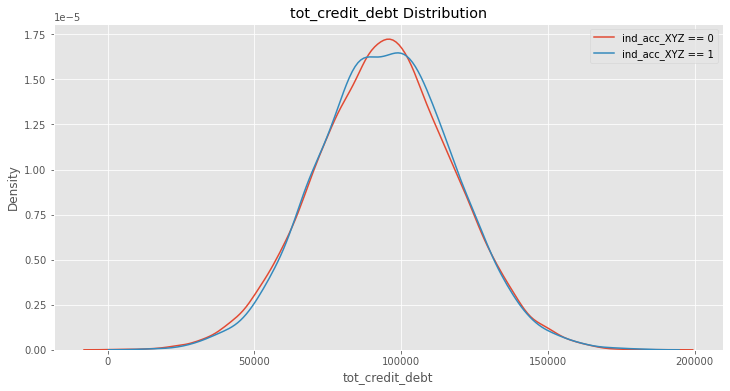

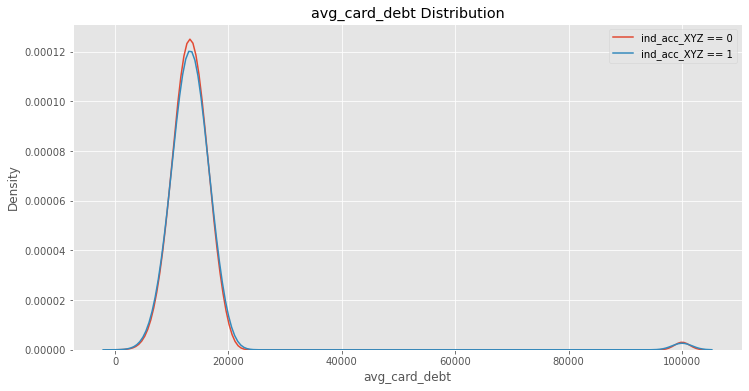

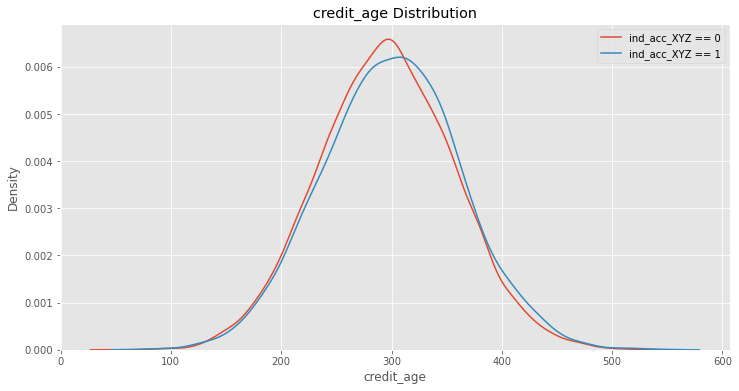

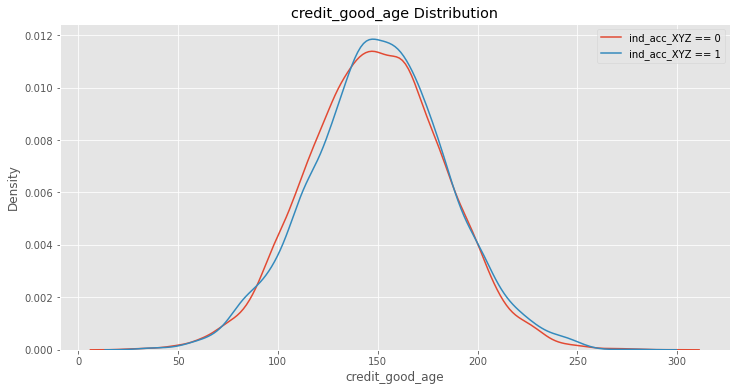

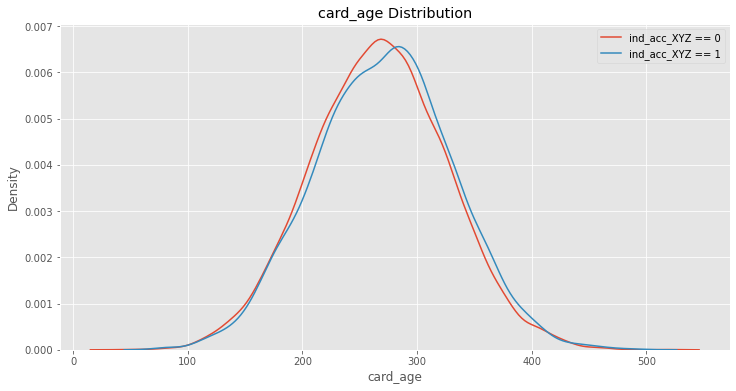

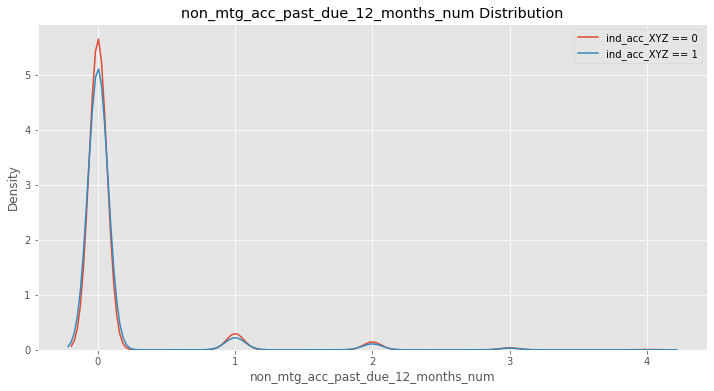

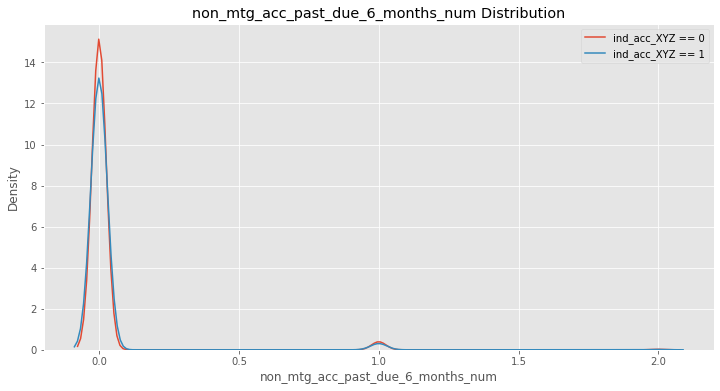

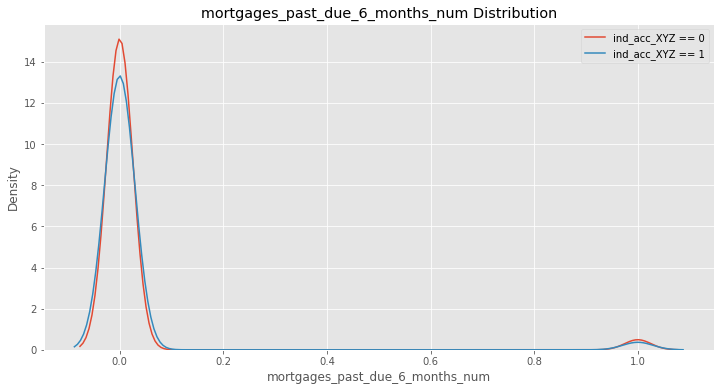

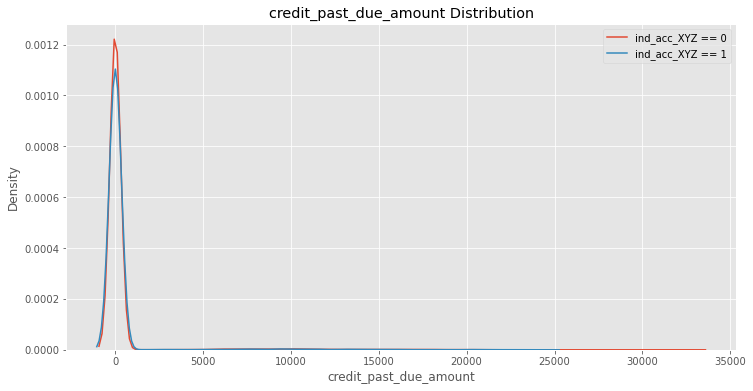

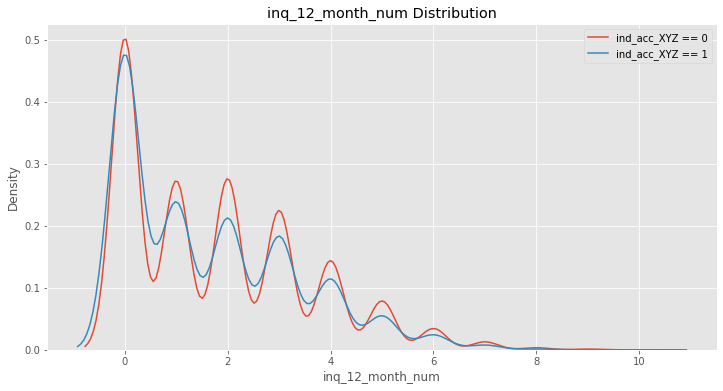

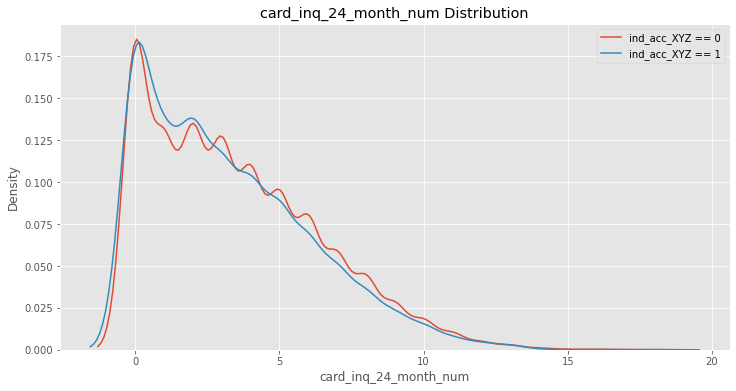

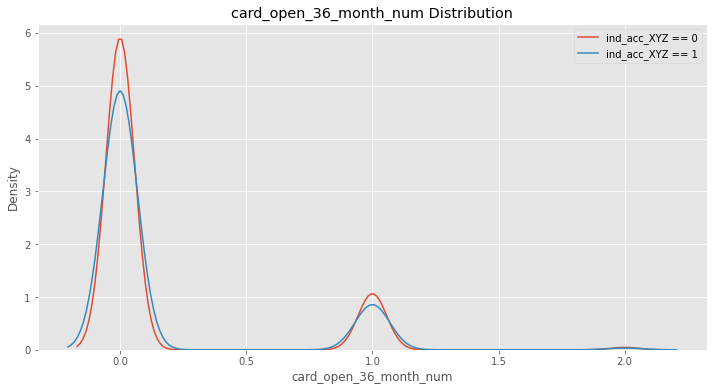

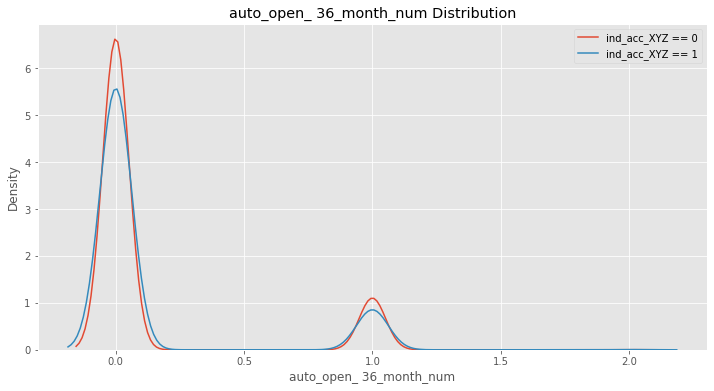

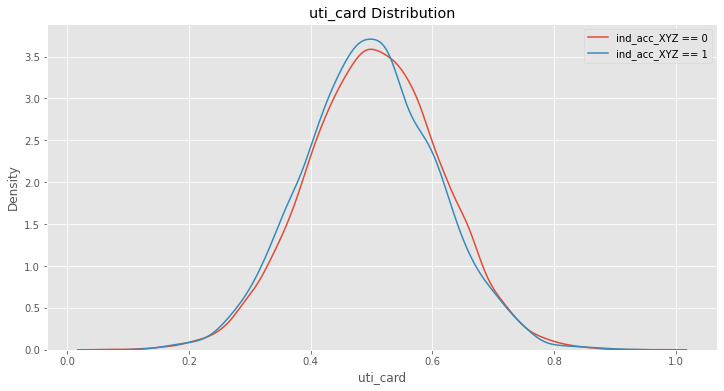

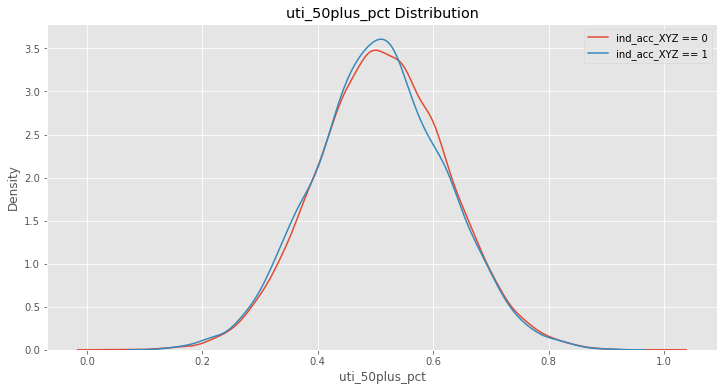

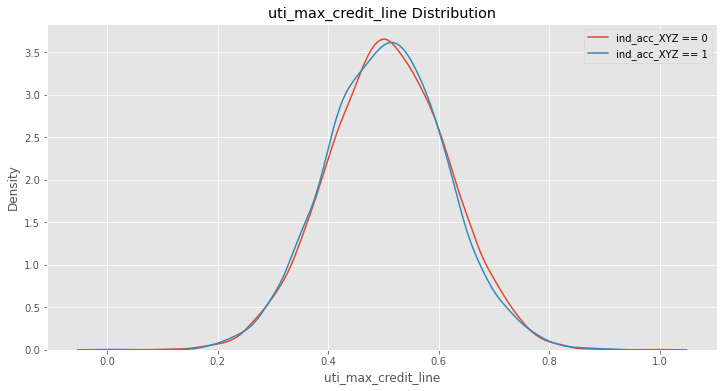

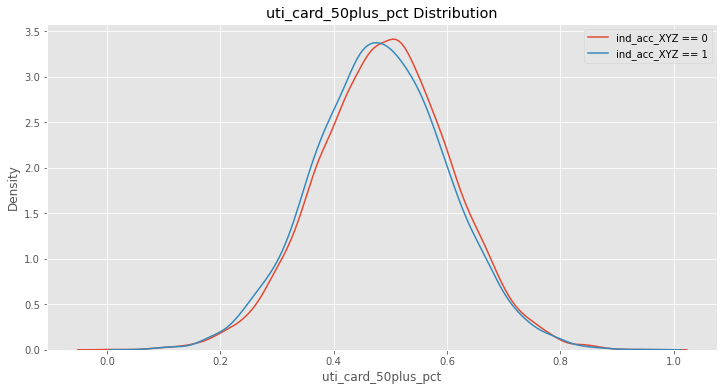

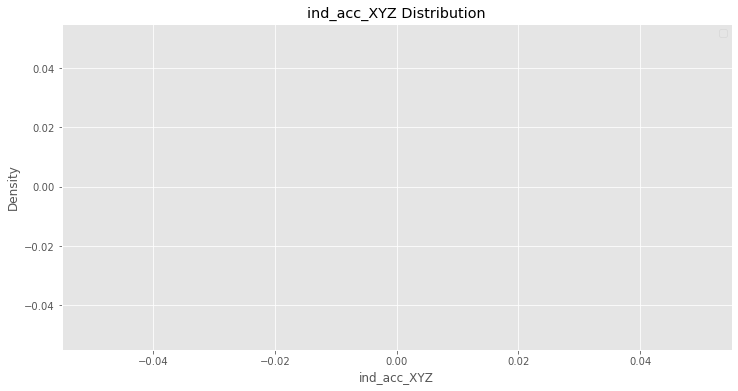

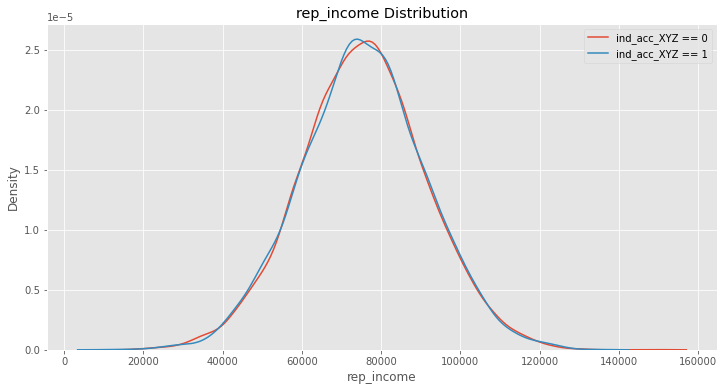

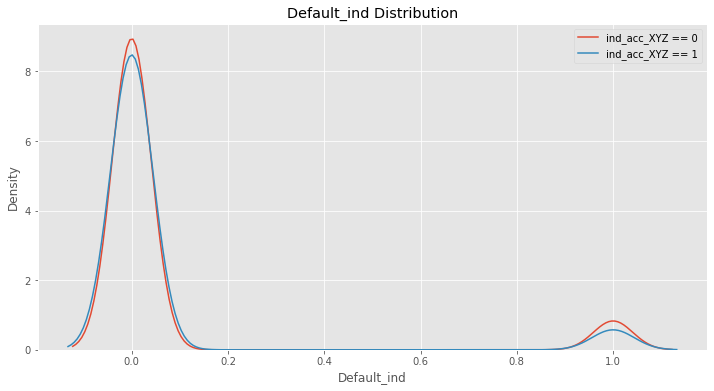

In [15]:
# Evaluating effect on ind_XYZ
for var in list(train.columns):
    kde_target_treatment(var,train)

In [16]:
#Create two new variables - reported income doesn't give us what we want

train["income_debt_ratio"] =train["avg_card_debt"]/ train["rep_income"]
train["bad_debt_ratio"] =train["avg_card_debt"]/ train["tot_credit_debt"]
train = train.drop('rep_income',axis = 1)
train = train.drop('tot_credit_debt',axis = 1)



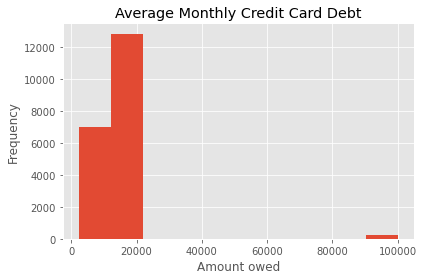

In [17]:
plt.hist(train['avg_card_debt'])
plt.title('Average Monthly Credit Card Debt')
plt.xlabel('Amount owed')
plt.ylabel('Frequency')
plt.tight_layout()

In [18]:
##Labels
y_train = train["Default_ind"].astype(bool)
y_test = test["Default_ind"].astype(bool)
## Training/Testing data
X_train = train.drop(columns=['Default_ind'])
X_test = test.drop(columns=['Default_ind'])
## Bank indicator to Bool , but saving it for later
X_train_ind = X_train["ind_acc_XYZ"].astype(bool)
X_test_ind = X_test["ind_acc_XYZ"].astype(bool)
## Removing Categoricals from DF, since state doesnt mean anything
X_train = X_train._get_numeric_data().drop(columns=["ind_acc_XYZ"])
X_test = X_test._get_numeric_data().drop(columns=["ind_acc_XYZ"])
X_train = X_train._get_numeric_data()
X_test = X_test._get_numeric_data()

In [19]:
y_validate = validate["Default_ind"].astype(bool)
X_validate = validate.drop(columns=['Default_ind'])
X_validate_ind = X_validate["ind_acc_XYZ"].astype(bool)
X_validate = X_validate._get_numeric_data().drop(columns=["ind_acc_XYZ"])
X_validate = X_validate._get_numeric_data()

## Dimension Reduction - Factor Analysis

In [20]:
#indicates good fit for factor analysis
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

scaled_df_train = MinMaxScaler().fit_transform(X_train)

chi_square_value,p_value=calculate_bartlett_sphericity(scaled_df_train)
print(chi_square_value, p_value)

#KMO
#Value should be 0.6<
kmo_all,kmo_model=calculate_kmo(scaled_df_train)
print(kmo_model)


289310.4280847032 0.0
0.7501686660500716


In [21]:
fa = FactorAnalyzer(5, rotation="varimax", method='minres', use_smc=True)

fa.fit(X_train)

# fa_test = FactorAnalyzer(5, rotation="varimax", method='minres', use_smc=True)

# fa_test.fit(X_test)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [22]:
loadings = pd.DataFrame(fa.loadings_, columns=['Past Delinquency', 'Card Utilization', 'Credit Age', 'Recent Inquiries','Current Debt'], index=X_train.columns)

# loadings2 = pd.DataFrame(fa_test.loadings_, columns=['Past Delinquency', 'Card Utilization', 'Credit Age', 'Recent Inquiries','Current Debt'], index=X_test.columns)

In [23]:
fa.get_factor_variance()

(array([3.3334345 , 2.8592529 , 2.49435102, 2.46582517, 1.72023427]),
 array([0.18519081, 0.15884738, 0.13857506, 0.13699029, 0.09556857]),
 array([0.18519081, 0.34403819, 0.48261325, 0.61960353, 0.7151721 ]))

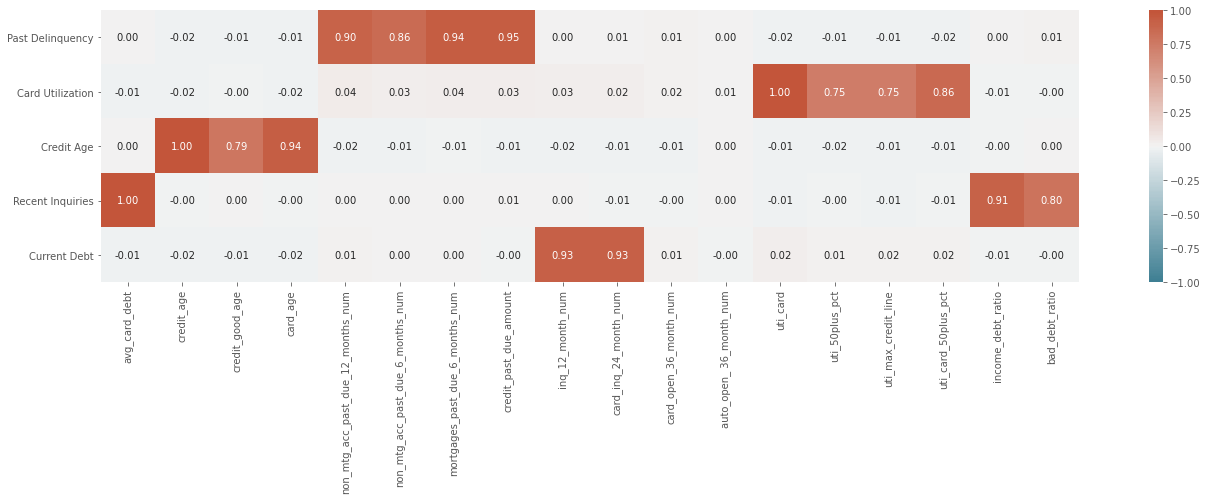

In [24]:

plt.figure(figsize=(25,5))

# plot the heatmap for correlation matrix
ax = sns.heatmap(loadings.T,
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(220, 20, n=200),
                 square=True, annot=True, fmt='.2f')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0);

In [25]:
factors_train=fa.fit_transform(X_train)
factors_test=fa.fit_transform(X_test)
factors_validate = fa.fit_transform(X_validate)

In [26]:
Fa_train_df = pd.DataFrame(factors_train, columns=['Past Delinquency', 'Card Utilization', 'Credit Age', 'Recent Inquiries','Current Debt'])
Fa_test_df = pd.DataFrame(factors_test, columns=['Past Delinquency', 'Card Utilization', 'Credit Age', 'Recent Inquiries','Current Debt'])
Fa_val_df = pd.DataFrame(factors_validate, columns=['Past Delinquency', 'Card Utilization', 'Credit Age', 'Recent Inquiries','Current Debt'])

In [27]:
# If we wanted to add states - HAS NO AFFECT ON THE MODEL
# Fa_train_df=pd.concat([Fa_train_df, pd.get_dummies(train_states)],axis=1)
# Fa_test_df=pd.concat([Fa_test_df, pd.get_dummies(test_states)],axis=1)
# Fa_val_df= pd.concat([Fa_val_df, pd.get_dummies(validate_states)],axis=1)

## Model Construction

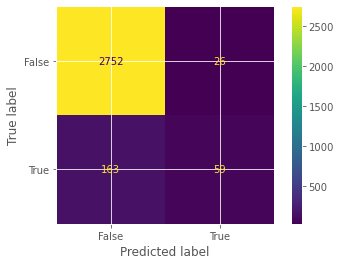

In [28]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

clf = LogisticRegression(random_state=42,C=.05).fit(Fa_train_df, y_train)
y_pred = clf.predict(Fa_val_df)
plot_confusion_matrix(clf,Fa_val_df,y_validate)

## Model Selection / Assessment

In [29]:
#

def plot_maximize_model(model = clf, validation_df_X = Fa_val_df, validation_y = y_validate, metric = 'f1_score'):

    pred_proba_df = pd.DataFrame(model.predict_proba(validation_df_X))
    # threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
    threshold_list1 = np.arange(.15,.3,.01)
    f1_list = []


    conf_arr = []
    f1_score_arr = []
    roc_auc_score_arr = []
    precision_score_arr = []
    recall_score_arr = []
    idx = 0
    for i in threshold_list1:
        Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)

        conf_arr.append(confusion_matrix(validation_y,Y_test_pred.iloc[:,-1:]))
    #     confusion_matrix(y_validate,Y_test_pred.iloc[:,-1:]))

        f1_score_arr.append(f1_score(validation_y,Y_test_pred.iloc[:,-1:]))

        roc_auc_score_arr.append(roc_auc_score(validation_y,Y_test_pred.iloc[:,-1:]))

        precision_score_arr.append(precision_score(validation_y,Y_test_pred.iloc[:,-1:]))

        recall_score_arr.append(recall_score(validation_y,Y_test_pred.iloc[:,-1:]))

#     conf_arr
#     f1_score_arr
#     roc_auc_score_arr
#     precision_score_arr
#     recall_score_arr

    model_dicts = {i: [conf_arr[i],f1_score_arr[i],roc_auc_score_arr[i], precision_score_arr[i], recall_score_arr[i]] for i in range(len(conf_arr))}


    # Select the best model - F1
    if metric == 'f1_score':
        model = sorted(model_dicts.values(),key = lambda x: -x[1])[0]
    # Select the best model - AUROC
    if metric == 'auc_roc':
        model = sorted(model_dicts.values(),key = lambda x: -x[2])[0]
    # Select the best model - Precision
    if metric == 'precision':
        model = sorted(model_dicts.values(),key = lambda x: -x[3])[0]
    # Select the best model - Recall
    if metric == 'recall':
        model = sorted(model_dicts.values(),key = lambda x: -x[4])[0]

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(model[0], annot=True, annot_kws={"size": 16},cmap= 'viridis',square=True,fmt = "") # font size
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()



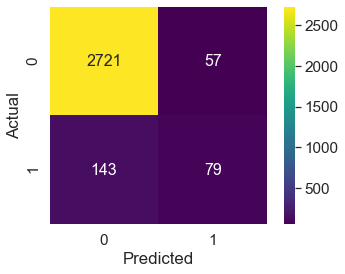

In [30]:
# View confusion matrix based on method
plot_maximize_model(metric = 'precision')

In [31]:
print("Intercept: " , clf.intercept_[0])

coef_df = pd.DataFrame({'Coef':clf.coef_[0]},index = ['Past Delinquency', 'Card Utilization', 'Credit Age', 'Recent Inquiries','Current Debt'])
coef_df['log_coef'] = np.exp(coef_df['Coef'])

coef_df


Intercept:  -2.993725089078479


Coef  log_coef
Past Delinquency  0.746302  2.109186
Card Utilization  0.718956  2.052289
Credit Age       -0.425868  0.653203
Recent Inquiries  0.286103  1.331230
Current Debt      0.348755  1.417302

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = clf.predict_proba(Fa_val_df)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
ns_probs = [0 for _ in range(len(y_validate))]

# calculate scores
ns_auc = roc_auc_score(y_validate, ns_probs)
lr_auc = roc_auc_score(y_validate, lr_probs)

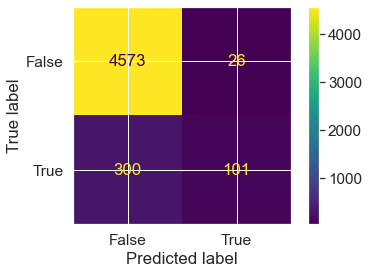

In [33]:
# View our results on test data
plot_confusion_matrix(clf, Fa_test_df, y_test)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.810


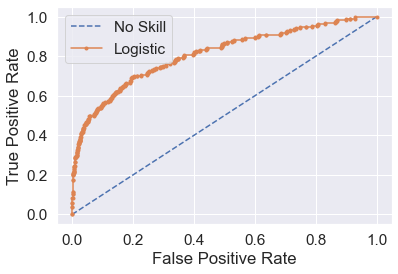

In [34]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_validate, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_validate, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Does Wells Fargo treat prior customers differently?**

0.380327868852459

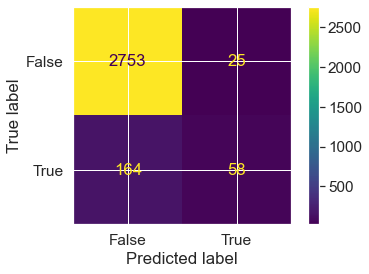

In [35]:
Fa_val_df['ind_acc_XYZ']= X_validate_ind
Fa_val_df
Fa_test_df['ind_acc_XYZ']= X_test_ind
Fa_test_df
Fa_train_df['ind_acc_XYZ']= X_train_ind
Fa_train_df


clf = LogisticRegression(random_state=42,).fit(Fa_train_df, y_train)
y_pred = clf.predict(Fa_val_df)
clf.score(Fa_val_df,y_validate)
plot_confusion_matrix(clf,Fa_val_df,y_validate)
f1_score(y_validate,y_pred)

#Gradient Boosing code--------------------------



In [36]:
train = pd.read_csv("../Data/Simulated_Data_Train.csv")
test = pd.read_csv("../Data/Simulated_Data_Test.csv")
val=pd.read_csv("../Data/Simulated_Data_Validation.csv")

In [37]:
#Saving states on its own so we can add it back after imputing
train_states = train["States"]
test_states = test["States"]
val_states = val["States"]

imputer = IterativeImputer()
#fitting imputer only on training data
fit_imputer = imputer.fit(train.drop('States',axis=1))

In [38]:

train_mice_imputed= pd.DataFrame(imputer.transform(train.drop('States',axis=1)),columns=train.drop('States',axis=1).columns)
test_mice_imputed= pd.DataFrame(imputer.transform(test.drop('States',axis=1)),columns=test.drop('States',axis=1).columns)
val_mice_imputed= pd.DataFrame(imputer.transform(val.drop('States',axis=1)),columns=val.drop('States',axis=1).columns)
#Bringing back States after imputing (wont work with Strings)
train_mice_imputed["States"] = train_states
test_mice_imputed["States"] = test_states
val_mice_imputed["States"] = val_states


In [39]:
train.dtypes

tot_credit_debt                       float64
avg_card_debt                         float64
credit_age                            float64
credit_good_age                       float64
card_age                              float64
non_mtg_acc_past_due_12_months_num    float64
non_mtg_acc_past_due_6_months_num     float64
mortgages_past_due_6_months_num       float64
credit_past_due_amount                float64
inq_12_month_num                      float64
card_inq_24_month_num                 float64
card_open_36_month_num                float64
auto_open_ 36_month_num               float64
uti_card                              float64
uti_50plus_pct                        float64
uti_max_credit_line                   float64
uti_card_50plus_pct                   float64
ind_acc_XYZ                           float64
rep_income                            float64
States                                 object
Default_ind                           float64
dtype: object

<AxesSubplot:>

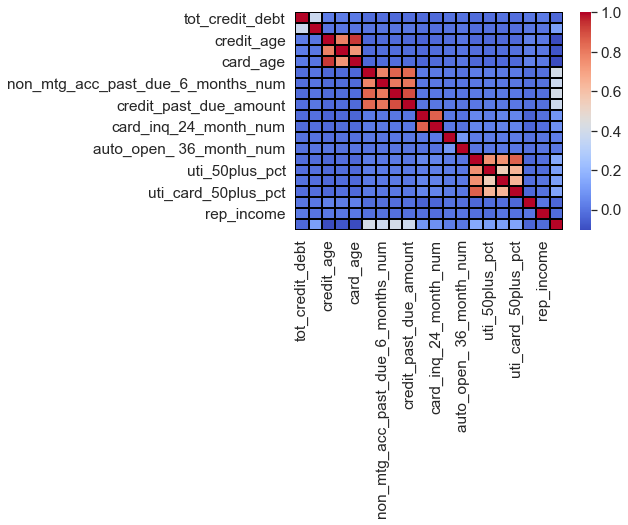

In [40]:
sns.heatmap(train_mice_imputed._get_numeric_data().corr(),cmap= 'coolwarm',linewidths=1, linecolor='black')

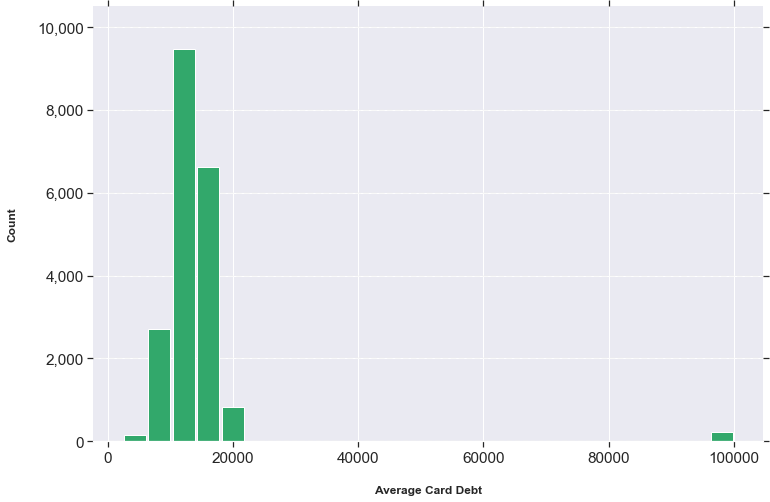

In [41]:
ax = train.hist(column='avg_card_debt', bins=25, grid=True, figsize=(12,8), color='#32a86b', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Average Card Debt", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

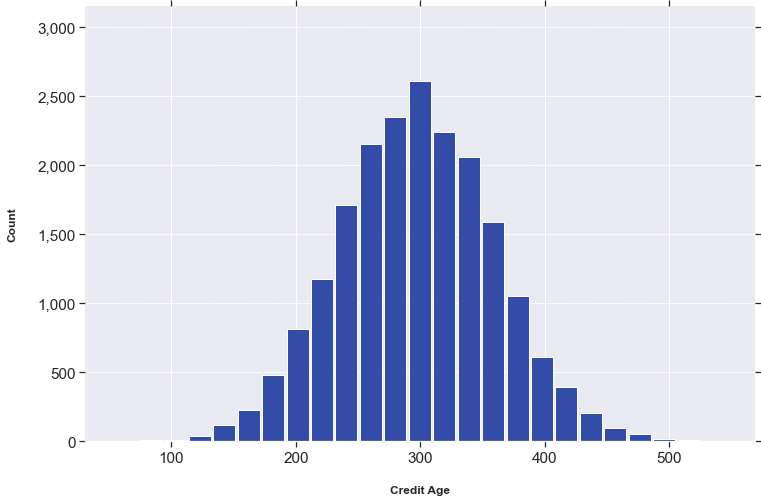

In [42]:
ax = train.hist(column='credit_age', bins=25, grid=True, figsize=(12,8), color='#324ca8', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Credit Age", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

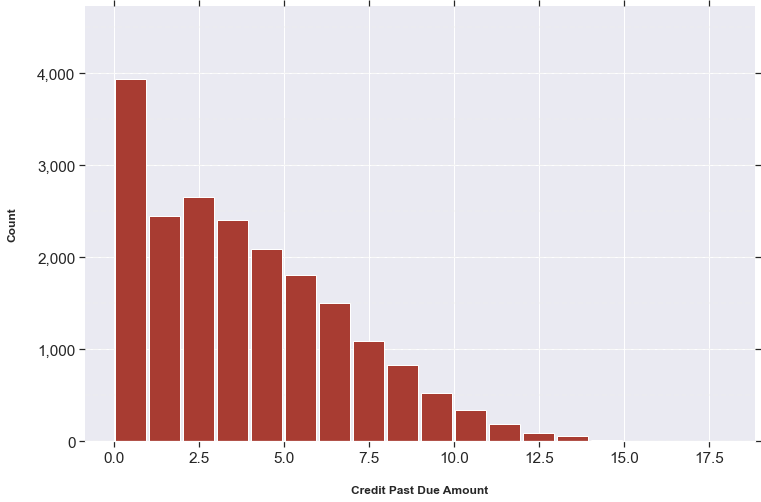

In [43]:
ax = train.hist(column='card_inq_24_month_num', bins=18, grid=True, figsize=(12,8), color='#a83c32', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Credit Past Due Amount", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [44]:
#Kernel density estimatioin

def kde_target(var_name,target_name, df):

    # Calculate the correlation coefficient between the new variable and the target
    corr = df[target_name].corr(df[var_name])

            # Calculate medians for default vs not default
    avg_not_default = df.loc[df[target_name] == 0, var_name].median()
    avg_default = df.loc[df[target_name] == 1, var_name].median()

    plt.figure(figsize = (12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df[target_name] == 0, var_name], label = '%s == 0'% target_name)
    sns.kdeplot(df.loc[df[target_name] == 1, var_name], label = '%s == 1'% target_name)

    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();

    # print out the correlation
    print('The correlation between %s and the %s is %0.4f' % (var_name,target_name, corr))
    # Print out average values
    print('Median value for non defaults = %0.4f' % avg_not_default)
    print('Median value for defaults =     %0.4f' % avg_default)

The correlation between uti_50plus_pct and the Default_ind is 0.1215
Median value for non defaults = 0.5063
Median value for defaults =     0.5587
The correlation between rep_income and the Default_ind is -0.0168
Median value for non defaults = 75511.8446
Median value for defaults =     75211.4325
The correlation between credit_age and the Default_ind is -0.1024
Median value for non defaults = 299.0000
Median value for defaults =     274.0000
The correlation between avg_card_debt and the Default_ind is 0.1195
Median value for non defaults = 13251.2400
Median value for defaults =     13125.5300


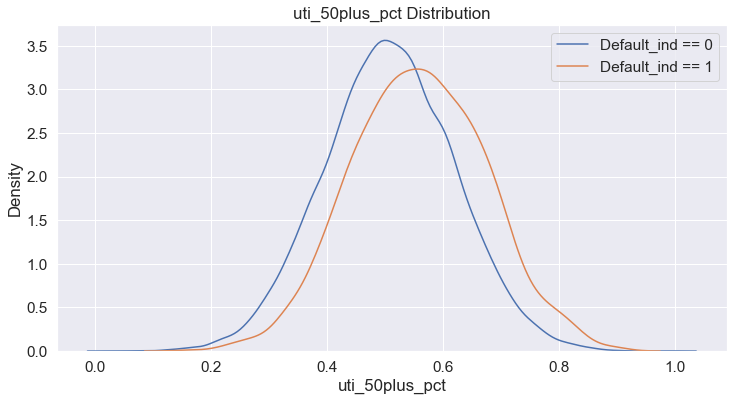

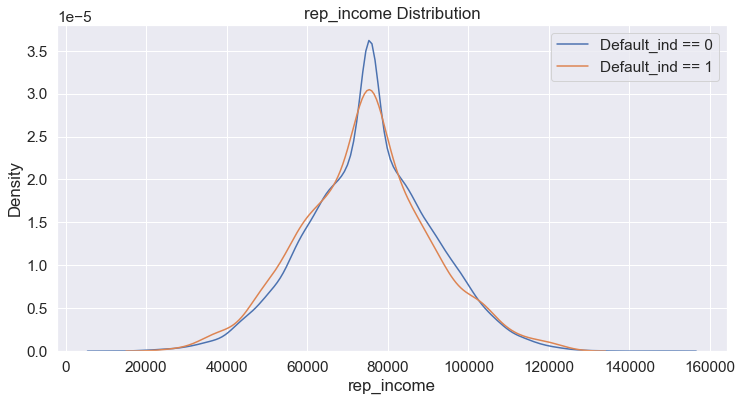

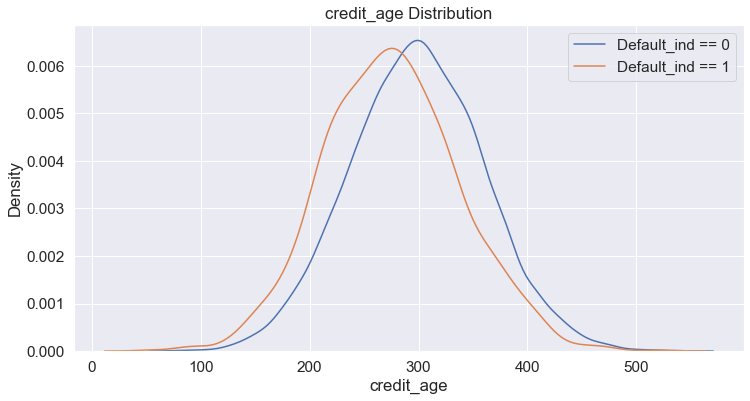

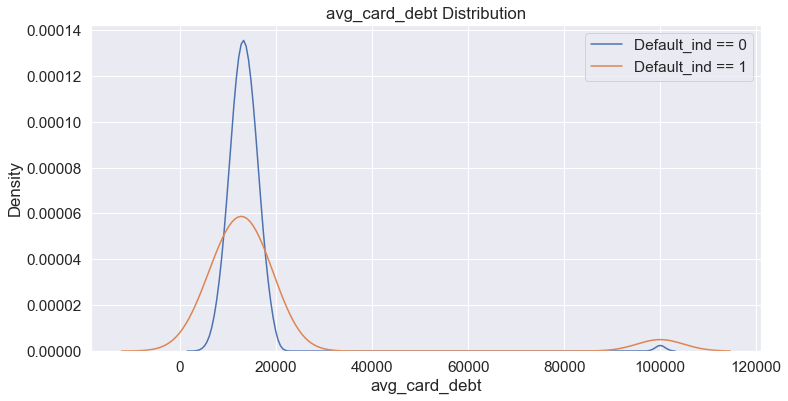

In [45]:
kde_target("uti_50plus_pct","Default_ind",train_mice_imputed)
kde_target("rep_income","Default_ind",train_mice_imputed)
kde_target("credit_age","Default_ind",train_mice_imputed)
kde_target("avg_card_debt","Default_ind",train_mice_imputed)

In [46]:
# takes the name of the column we want to extract and will 'spit out' the data column of our Data Frame

from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.feature_names]

In [47]:
#takes as an input function that decides whether or not label value as True or False

class Binarizer(BaseEstimator, TransformerMixin):

    def __init__(self, condition, name):
        self.condition = condition
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(lambda x : int(self.condition(x))).to_frame(self.name)

In [48]:
#Take Mean of multiple columns

class MeanTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, name):
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.mean(axis=1).to_frame(self.name)

In [49]:
## To turn States into Dummies (eventually unused since States mean nothing)

class Dummify(BaseEstimator, TransformerMixin):

    def __init__(self, name):
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.get_dummies(X)

In [50]:
#Sums across multiple variables

class SumTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, series_name):
        self.series_name = series_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.sum(axis=1).to_frame(self.series_name)


In [51]:
#Union function to wrap pandas dataframes from SKlearn pipelines

class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

def make_union(*transformers, **kwargs):
    n_jobs = kwargs.pop('n_jobs', None)
    verbose = kwargs.pop('verbose', False)
    if kwargs:
        raise TypeError('Unknown keyword arguments: "{}"'
                        .format(list(kwargs.keys())[0]))
    return PandasFeatureUnion(
        _name_estimators(transformers), n_jobs=n_jobs, verbose=verbose)

In [52]:
# Unions all these mini pipelines
# Im sure there is a better way to do this help me

union = make_union(
    make_pipeline(
        FeatureSelector(['non_mtg_acc_past_due_12_months_num', 'non_mtg_acc_past_due_6_months_num','mortgages_past_due_6_months_num']),
        SumTransformer('past_due_acct_sum')
    ),
    make_pipeline(
        FeatureSelector(['inq_12_month_num', 'card_inq_24_month_num','card_open_36_month_num','auto_open_ 36_month_num']),
        SumTransformer('past_inq_sum')
    ),
    make_pipeline(
        FeatureSelector(['uti_card', 'uti_50plus_pct','uti_max_credit_line','uti_card_50plus_pct']),
        MeanTransformer('mean_card_util')
    ),
    make_pipeline(
        FeatureSelector(['credit_age', 'credit_good_age','card_age']),
        MeanTransformer('mean_credit_age')
    ),
    make_pipeline(
        FeatureSelector(['avg_card_debt',
                        # 'credit_past_due_amount',
                        'ind_acc_XYZ'
                         ])
    )
)

In [99]:
#Splitting the X,Y for each Dataset

X_train = train_mice_imputed.drop(columns="Default_ind")
y_train = train_mice_imputed["Default_ind"].astype(bool
                                                   )
X_test = test_mice_imputed.drop(columns="Default_ind")
y_test = test_mice_imputed["Default_ind"].astype(bool)

X_val = val_mice_imputed.drop(columns="Default_ind")
y_val = val_mice_imputed["Default_ind"].astype(bool)

In [100]:
#Fitting our union function on our Training Data

union.fit(X_train)

PandasFeatureUnion(transformer_list=[('pipeline-1',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_names=['non_mtg_acc_past_due_12_months_num',
                                                                                      'non_mtg_acc_past_due_6_months_num',
                                                                                      'mortgages_past_due_6_months_num'])),
                                                      ('sumtransformer',
                                                       SumTransformer(series_name='past_due_acct_sum'))])),
                                     ('pipeline-2',
                                      Pipeline(steps=[('featureselector',
                                                       Feat...
                                                      ('meantransformer',
                                                       Mean

In [101]:
#Fitting Each Dataset with the training-fitted Union function to avoid leakage
# I know this could have been done in a simpler way, but I wanted a clear way to fit all the datasets with the same transformations in a single function in order to minimize the chance of using any validation and test data in any model fitting/feature enginerring
X_train = union.transform(X_train).astype('float')
X_test = union.transform(X_test).astype('float')
X_val = union.transform(X_val).astype('float')

In [102]:
X_train.head()

past_due_acct_sum  past_inq_sum  mean_card_util  mean_credit_age  \
0                0.0           7.0        0.403266       235.333333   
1                0.0           7.0        0.552111       205.000000   
2                0.0           5.0        0.351865       223.333333   
3                4.0           2.0        0.457426       181.000000   
4                0.0           2.0        0.599778       208.666667   

   avg_card_debt  ind_acc_XYZ  
0       15872.99          0.0  
1       12178.02          0.0  
2       12052.24          0.0  
3        8416.80          0.0  
4       10611.97          1.0

In [103]:
#This is only to show a comparison of before/after transformation
X_train_temp = X_train.copy()
X_train_temp["Default_ind"] = y_train

The correlation between uti_50plus_pct and the Default_ind is 0.1215
Median value for non defaults = 0.5063
Median value for defaults =     0.5587
The correlation between mean_card_util and the Default_ind is 0.1506
Median value for non defaults = 0.4986
Median value for defaults =     0.5554


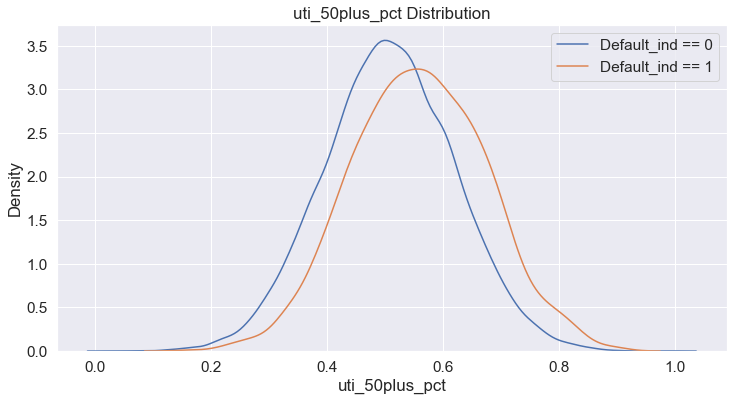

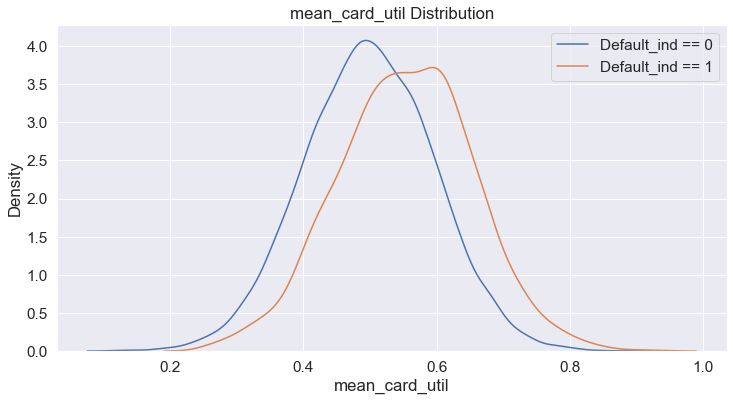

In [104]:
# After transformations, the combined columns have more predictive power
kde_target("uti_50plus_pct","Default_ind",train_mice_imputed)
kde_target("mean_card_util","Default_ind",X_train_temp)

<AxesSubplot:>

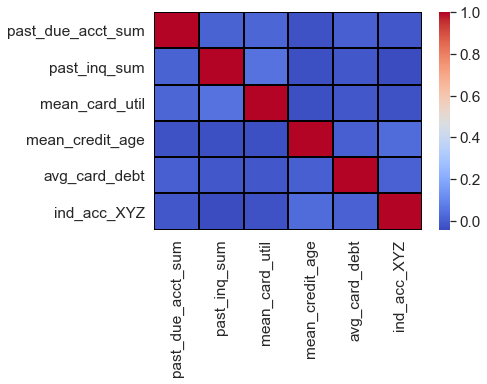

In [105]:
#Corr Heatmap of training data, low multicolinearity
sns.heatmap(X_train.corr(),cmap= 'coolwarm',linewidths=1, linecolor='black')

In [106]:
# Default XGBoost model fit
model = xgb.XGBClassifier(objective="binary:logistic",random_state=54)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

[13:54:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


F1 Score : 0.9266
              precision    recall  f1-score   support

       False       0.95      0.99      0.97      4599
        True       0.72      0.35      0.47       401

    accuracy                           0.94      5000
   macro avg       0.83      0.67      0.72      5000
weighted avg       0.93      0.94      0.93      5000



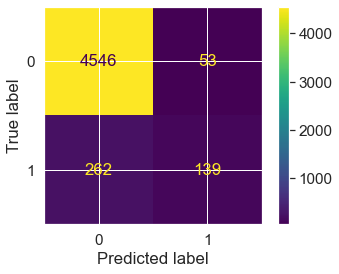

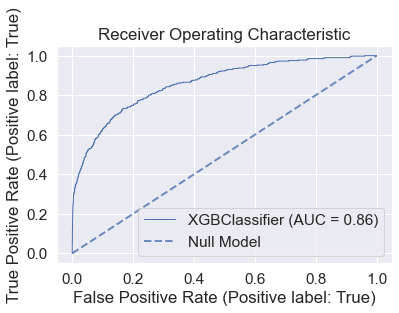

In [107]:
# Diagnostics
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred))
disp.plot()
print("F1 Score : %0.4f" %  f1_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test,(y_test_pred>0.5)))


fig, ax = plt.subplots()
metrics.plot_roc_curve(model, X_test, y_test, lw=1, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b',
        label='Null Model', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

In [126]:

## Bayesian Hyperparameter Optimization
def xgb_classifier(max_depth, reg_alpha,
                   reg_lambda, min_child_weight,
                   gamma,scale_pos_weight,base_score,learning_rate):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "aucpr",
              "scale_pos_weight" : scale_pos_weight,
              "base_score" : base_score,
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "min_child_weight" : int(min_child_weight),
              "learning_rate" : learning_rate,
              "seed" : 342,
              "verbosity" : 1}
    val_data = xgb.DMatrix(X_val, y_val)
    cv_result = xgb.cv(params,
                       val_data,
                       2000,
                       early_stopping_rounds=200,
                       stratified=True,
                       nfold=5)
    return cv_result['test-aucpr-mean'].iloc[-1]

In [127]:
# Setting parameter space
pbounds = {'max_depth': (2, 40),
           'reg_alpha': (0.0, 0.1),
           'reg_lambda': (0.0, 0.1),
           'min_child_weight': (1, 10),
           "gamma": (0, 10),
           "scale_pos_weight": (1, 100),
           "base_score": (0.01, .99),
           "learning_rate": (0, 1)
           }

In [128]:
# Running the maximization alg

xgbBO = BayesianOptimization(f = xgb_classifier,pbounds=pbounds)

xgbBO.maximize(n_iter=50, init_points=5)

|   iter    |  target   | base_s... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | scale_... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.4835   |  0.6036   |  8.229    |  0.3717   |  32.0     |  6.249    |  0.0853   |  0.0546   |  21.37    |
|  2        |  0.4507   |  0.4544   |  5.046    |  0.845    |  27.12    |  9.292    |  0.03791  |  0.09679  |  59.4     |
|  3        |  0.4702   |  0.7731   |  2.724    |  0.7307   |  30.6     |  9.806    |  0.09682  |  0.0793   |  63.16    |
|  4        |  0.4346   |  0.1632   |  3.801    |  0.5757   |  14.88    |  1.975    |  0.06422  |  0.07666  |  25.2     |
|  5        |  0.4425   |  0.5243   |  0.1405   |  0.8174   |  4.484    |  4.223    |  0.04356  |  0.07408  |  41.61    |
|  6        |  0.481    |  0.8915   |  6.355    |  0.1276   |  25.51    |  8.882    |  0.03843  |  0.05129  |  61.45    |
|  7        |  0.4708   

|  41       |  0.4995   |  0.5955   |  9.455    |  0.1983   |  34.46    |  6.488    |  0.005901 |  0.03485  |  23.6     |
|  42       |  0.4665   |  0.7361   |  8.51     |  0.6092   |  36.85    |  6.663    |  0.05919  |  0.09473  |  24.85    |
|  43       |  0.4794   |  0.6381   |  9.093    |  0.3389   |  35.01    |  4.483    |  0.03626  |  0.008793 |  24.58    |
|  44       |  0.4958   |  0.6553   |  7.196    |  0.3573   |  36.72    |  9.78     |  0.07197  |  0.04178  |  21.82    |
|  45       |  0.4313   |  0.1058   |  8.292    |  0.4896   |  35.2     |  6.679    |  0.06549  |  0.02715  |  26.59    |
|  46       |  0.4444   |  0.6103   |  8.215    |  0.9939   |  35.4     |  9.458    |  0.01292  |  0.01062  |  24.41    |
|  47       |  0.074    |  0.01     |  9.049    |  0.0      |  37.55    |  9.58     |  0.1      |  0.1      |  22.61    |
|  48       |  0.4841   |  0.02313  |  7.232    |  0.09787  |  34.97    |  7.967    |  0.05674  |  0.05375  |  21.84    |
|  49       |  0.4644   

In [129]:
best_params = xgbBO.max["params"]
for param in best_params:
    print("%s : %0.4f" % (param,best_params[param]))

base_score : 0.5126
gamma : 6.1425
learning_rate : 0.0408
max_depth : 35.3378
min_child_weight : 8.5961
reg_alpha : 0.0778
reg_lambda : 0.0847
scale_pos_weight : 21.4108


In [130]:
# Fitting all params into a single dictionary to pass as **kwargs


def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res
base_params = {"objective" : "binary:logistic",
              "seed" : 342,
              "eval_metric":"aucpr"}

optimal_params = Merge(best_params, base_params)

#Max depth must be int
d1 = {"max_depth": (math.floor(optimal_params["max_depth"]))}
optimal_params.update(d1)

In [131]:
# Optimized XGBoost model fit

model = xgb.XGBClassifier(**optimal_params)

model.fit(X_train, y_train,eval_metric="aucpr")

y_test_pred = model.predict(X_test)

F1 Score : 0.8993
              precision    recall  f1-score   support

       False       0.97      0.91      0.94      4599
        True       0.38      0.66      0.48       401

    accuracy                           0.89      5000
   macro avg       0.67      0.78      0.71      5000
weighted avg       0.92      0.89      0.90      5000



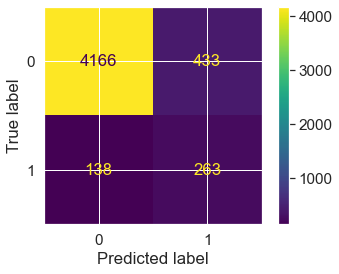

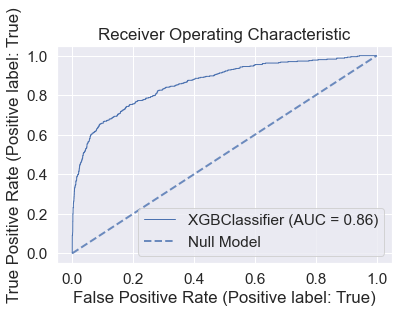

In [132]:
# Diagnostics
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred))
disp.plot()
print("F1 Score : %0.4f" %  f1_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test,(y_test_pred>0.5)))


fig, ax = plt.subplots()
metrics.plot_roc_curve(model, X_test, y_test, lw=1, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b',
        label='Null Model', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

In [138]:
class_names = np.array(["Not Default","Default"])
f_names_list = list(X_train.columns)

feature_names = np.array(f_names_list)

In [139]:
X_test_np = X_test.to_numpy()

explainer = lime_tabular.LimeTabularExplainer(X_train.to_numpy(), mode="classification",
                                              feature_names=f_names_list,
                                              class_names=class_names)

explainer

In [140]:
idx = random.randint(1, len(X_test_np))

explanation = explainer.explain_instance(X_test_np[idx], model.predict_proba,
                                         num_features=len(list(X_test.columns)))

In [141]:
explanation.show_in_notebook()

100%|===================| 19991/20000 [04:10<00:00]        

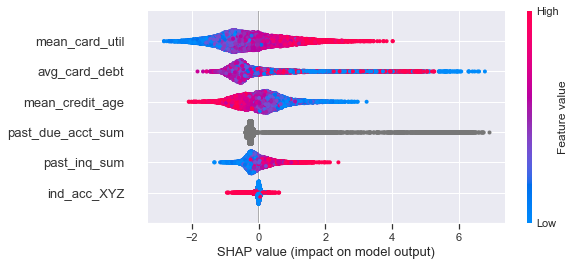

In [146]:
e = shap.TreeExplainer(model, X_train)
shap_values = e.shap_values(X_train)
X_train.iloc[:,0] = np.nan
shap.summary_plot(shap_values, X_train)

In [147]:
from pydotplus import graph_from_dot_data
from IPython.display import Image
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
sub_tree_42 = model.estimators_[42, 0]

# Visualization. Install graphviz in your system

dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())

AttributeError: 'XGBClassifier' object has no attribute 'estimators_'